# Statistics of VCF
* Length Distribtuion of each SV
* Number of SVs per chromosome
* Number of SVs per chromosome per person
* Distribution of alternative allele frequency
* Distribtuion of missing rate

## Length Distribtuion of each SV

In [1]:
#! /bin/python3.6.1
# Length distribution of each type of structural variants. 
# Use the SV_Parser result, count how many DUPs, DELs, and INVs were found, and plot length distribution. 
def SVtypeCounter(filename):
    deletion=0
    delLength=[]
    duplication=0
    dupLength=[]
    inversion=0
    invLength=[]
    with open(filename,'r') as f:
        f.readline()
        for line in f:
            temp=line.strip().split()
            SVtype=temp[0]
            SVlength=abs(int(temp[2]))
            if SVtype =='DEL' or SVtype =='<DEL>':
                deletion+=1
                delLength.append(SVlength)
            elif SVtype=='DUP' or SVtype =='<DUP>':
                duplication+=1
                dupLength.append(SVlength)
            elif SVtype=='INV' or SVtype =='<INV>':
                inversion+=1
                invLength.append(SVlength)
    print("Deletion: %s \nDuplication: %s \nInversion: %s"%(deletion,duplication,inversion))
    import matplotlib.pyplot as plt
    plt.hist(delLength,100)
    plt.yscale('log', nonposy='clip') # without nonposy='clip', the show is abnormal
    plt.title('Deletion')
    plt.xlabel('SV length')
    plt.ylabel('Number')
    plt.show()
    
    if dupLength != []:
        plt.hist(dupLength,100)
        plt.yscale('log', nonposy='clip')
        plt.title('Duplication')
        plt.show()
    if invLength !=[]:
        plt.hist(invLength,100)
        plt.yscale('log', nonposy='clip')
        plt.title('Inversion')
        plt.show()
    #print(delLength)
    

Deletion: 8313 
Duplication: 0 
Inversion: 0


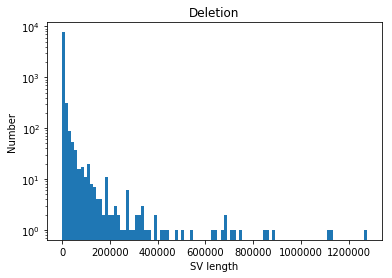

In [17]:
# Check the statisics of the vcf.stats
GSstats='/u/flashscratch/h/hjzhou/redo_discovery_out/deletions100k.svtoolkit2017April.mask/del100k_gt_redo/GS.passed.100k10mconcat.vcf.stats'
SVtypeCounter(GSstats)

## Number of SVs per chromosome

In [3]:
# Count the number of CNVs per chromosome and plot. (Does not take into account the genotype information)
def NumSVperChrom(vcfFile):
    from collections import Counter
    cnt=Counter()
    f=open(vcfFile)
    for line in f: # skip all the headers
        if line.strip().startswith('#CHROM'):
            #samplelist=line.strip().split()[9:]
            break
    for line in f: # start now for each CNV
        cnt[line.strip().split()[0]]+=1
    f.close()
    print(cnt)
    
    from matplotlib import pyplot as plt
    # next line is required for jupyter notework run on server
    #%matplotlib inline

    #Xticks names
    l=['chr'+str(i) for i in range(1,23)]
    l=l+['chrX','chrY']
    names = l
    values = [cnt[chrom] for chrom in names]

    #tick_label does the same work as plt.xticks()
    plt.bar(range(len(cnt)),values)
    plt.xticks(range(len(cnt)), names,rotation=70)
    plt.show()


Counter({'chr2': 654, 'chr1': 602, 'chr3': 576, 'chr4': 549, 'chr7': 523, 'chr6': 479, 'chr5': 460, 'chr8': 430, 'chr12': 376, 'chr11': 374, 'chr19': 330, 'chr9': 323, 'chr10': 322, 'chr14': 317, 'chr17': 302, 'chr13': 283, 'chrX': 256, 'chr16': 249, 'chr18': 240, 'chr15': 205, 'chr20': 174, 'chr22': 163, 'chr21': 106, 'chrY': 20})


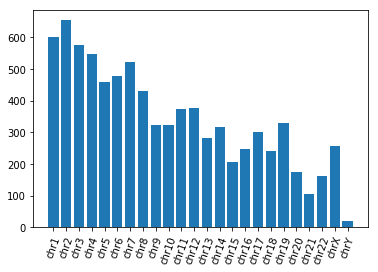

In [4]:
GSvcf='/u/flashscratch/h/hjzhou/redo_discovery_out/deletions100k.svtoolkit2017April.mask/del100k_gt_redo/GS.passed.100k10mconcat.vcf'
NumSVperChrom(GSvcf)

## Number of SVs per chromosome per person

In [8]:
# Count the number of SV on each chromosome for each person, and plot
def NumSVperChrperPerson(file): # input VCF
    f=open(file,'r')
    d={}
    for line in f:
        if line.startswith("##"): #skip headers
            continue
        else:
            samplelist=line.strip().split()[9:] #collect sample names
            totalnumber=len(samplelist)
            break
    for line in f:
        temp=line.strip().split() 
        CountList=[] # whether this site is in each individual or not
        for GT in temp[9:]:
            GT=GT.split(':')[0]
            if GT=='0/1' or GT=='1/1': # counted as 1
                CountList.append(1)
            else: # counted as 0
                CountList.append(0)
        if len(CountList)!= totalnumber:
            print('Attention!')
        if temp[0] not in d: # if chrom is not in d
            d[temp[0]]={}
            for indi in samplelist:
                d[temp[0]][indi]=0
        for i in range(totalnumber):
            if CountList[i] == 1:
                d[temp[0]][samplelist[i]]+=1 
            else:
                continue
                
##############
#in order to find out the outlier sample ID:
#     for indi in samplelist:
#         if d['chr1'][indi]<400:
#             print (indi)
###############   
    import pandas as pd
    df=pd.DataFrame.from_dict(d,'index')
    f.close()
    
    # l is chromosome list
    l=['chr'+str(i) for i in range(1,23)]
    l=l+['chrX','chrY']
    
    # reindex dataframe with l
    df=df.reindex(index=l)
    
    #plot
    import matplotlib.pyplot as plt
    %matplotlib inline 
    ax=df.plot(figsize=(20,15),legend=False)
    ax.set_xticks(range(len(l)))
    ax.set_xticklabels(l)
    ax.tick_params(axis='both', which='major', labelsize=15)
    

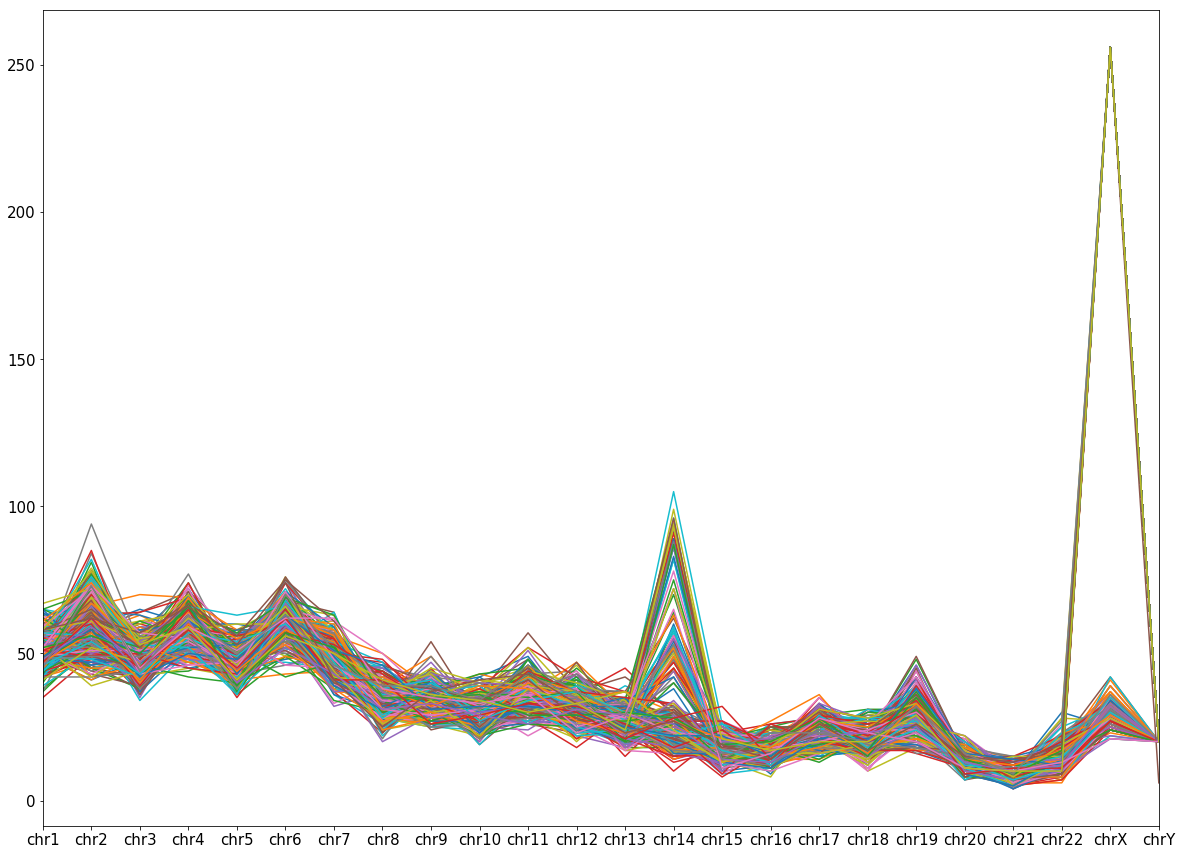

In [9]:
#Count the number of CNVs per chromosom per person for GenomeStrip result and plot
NumSVperChrperPerson(GSvcf)

## Distribution of alternative allele frequency

In [31]:
# distribution of alternative allele frequency (LUMPY and Genome STRiP)
# LUMPY:  DEL, DUP, and INV
def AAfrqD(file): # input stats file
    from matplotlib import pyplot as plt
    # next line is required for jupyter notework run on server
    %matplotlib inline
    
    f=open(file,'r')
    f.readline()# skip the header
    d={}
    d['DEL']=[]
    d['INV']=[]
    d['DUP']=[]
    for line in f:
        temp=line.strip().split()
        SVtype=temp[0]
        MAfrq=float(temp[3])
        d[SVtype].append(MAfrq)
    f.close()

    import matplotlib.pyplot as plt
    import math # for checking 'nan'
    for key in d.keys():
        if d[key]==[]:
            continue
        else:
            cleanlist=[x for x in d[key] if not math.isnan(x) ] # get rid of the 'nan'
            plt.hist(cleanlist,100)
            plt.title(key)
            plt.xlabel('Alternative allele frequency')
            #plt.yscale('log', nonposy='clip')
            plt.ylabel('Count')
            plt.show()

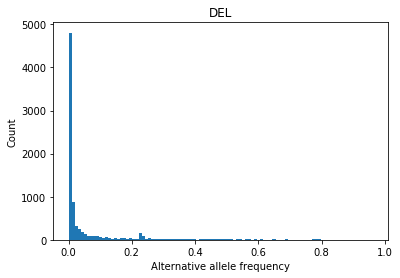

In [32]:
AAfrqD(GSstats)

## Distribtuion of missing rate

In [34]:
# Histogram of the site missing rate of the SVtyper output
# lmiss file generated by vcftools --missing-site
# Of note, Genome STRiP's missing rate cannot be detected by vcftool --missing-site, since it uses LQ in format GP column in VCF file to indicate low-quality genotyped sites.
def SiteMissingRate(lmissFile):
    f=open(lmissFile,'r')
    f.readline() #skip the first line
    missrates=[float(line.strip().split()[5]) for line in f]
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.hist(missrates,100)
    plt.title("SVtyper Site Missing Rate Distribution")
    plt.show()
    f.close()

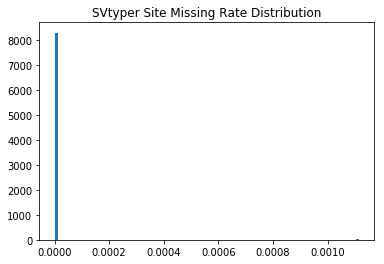

In [35]:
lmissFile='/u/flashscratch/h/hjzhou/redo_discovery_out/deletions100k.svtoolkit2017April.mask/del100k_gt_redo/GS.passed.100k10mconcat.lmiss'
SiteMissingRate(lmissFile)

In [37]:
# Histogram of the individal missing rate of the SVtyper output
def IndiMissingRate(imissFile): # lmiss file generated by vcftools --missing-indi
    f=open(imissFile,'r')
    f.readline() #skip the first line
    missrates=[float(line.strip().split()[4]) for line in f]
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.hist(missrates,100)
    plt.title("SVtyper Individual Missing Rate Distribution")
    plt.show()
    f.close()
    

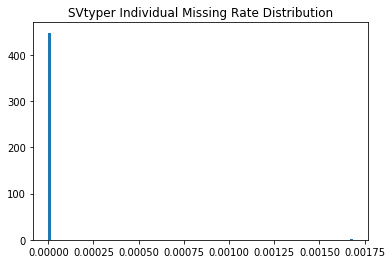

In [38]:
imissFile='/u/flashscratch/h/hjzhou/redo_discovery_out/deletions100k.svtoolkit2017April.mask/del100k_gt_redo/GS.passed.100k10mconcat.imiss'
IndiMissingRate(imissFile)